
NNFD: Neural Net Fluid Dynamics
=================

Proof-of-concept of timestepping solution to incompressible 2D simulation of flow around a cylinder (left to right) using neural networks.


Concept
-------
Value in cell $i$ in next time step $n+1$ is predicted from stencil surrounding $i$ at time $n$. The stencil can be interpreted as a filter, applied to each cell subsequently, in a poor-man's convolution operation.

Starts from computational fluid dynamics (CFD) solution of the same problem (incompressible finite difference solution on Cartesian homogeneous mesh, immersed boundary, fractional step method).



Current state
------------
Time advancement remains stable for ~200 steps. The ANN-driven simulation accurately captures the upward movement of the vortex in the wake of the cylinder. 

TODO
----
- proper boundary conditions
- reduce error of trained network
- simulation needs to be stabilized
- expand incorporate F in stencil into training



In [5]:
#movie of intermediate results
import io
import base64
from IPython.display import HTML

video = io.open('NNFD.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import torch

In [3]:
# file output

def writehead():
    varstring = '"i","k","U","W","F"'
    f = open("annoutfield.dat", "w")
    f.write('Title = "ANN Movie"\n')
    f.write('Variables='+varstring+'\n')
    print("writing head of moviefile...")

    
def writezone(df,n):
    print 'writing zone n = ',n
    f = open("annoutfield.dat", "a")
    annout = df #[df.t==n]

    f.write('Zone T=\"n='+str(n)+'\",I= '+str(imax)+', K='+str(kmax)+',F = POINT \n')

    for kk in range(1,kmax+1):
        for ii in range(1,imax+1):

            ikann = annout[(annout.i == ii) & (annout.k == kk)]
            iii = str(ikann.i.values[0])+' '
            kkk = str(ikann.k.values[0])+' '
            UUU = str(ikann.U.values[0])+' '
            WWW = str(ikann.W.values[0])+' '
            F   = str(ikann.F.values[0])+'\n'

            line = iii+kkk+UUU+WWW+F

            f.write(line)
    print 'Done'
    
    
    
def writenumpy(U,W,F,n):
    print 'writing zone n = ',n
    f = open("annoutfield.dat", "a")

    print 'ni,nk',imax,kmax
    f.write('Zone T=\"n='+str(n)+'\",I= '+str(imax)+', K='+str(kmax)+',F = POINT \n')

    for kk in range(0,kmax):
        for ii in range(0,imax):

            iii = str(ii)+' '
            kkk = str(kk)+' '
            UUU = str(U[kk,ii])+' '
            WWW = str(W[kk,ii])+' '
            FFF = str(F[kk,ii])+'\n'

            line = iii+kkk+UUU+WWW+FFF

            f.write(line)
    print 'Done'
    

/Developer/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


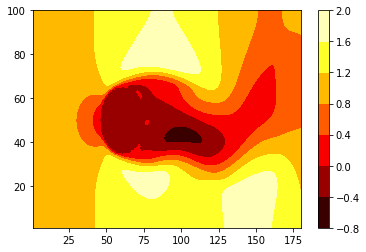

In [2]:
#read initial solution from CFD output and plot for control

cfd = pd.read_csv('fielddata.dat',header=0, delim_whitespace = True, usecols=['i','k','t','U','W','F'])
tinit = 1700

cfd0 = cfd[cfd.t==tinit]
cfd1 = cfd0

cfd0.t = 0
cfd1.t = 1

x = cfd0.i.unique()
y = cfd0.k.unique()

X, Y = np.meshgrid(x,y)
nx,ny = X.shape

Z = cfd0.U.values.reshape(nx,ny)
plt.contourf(X,Y,Z, cmap='hot')
plt.colorbar()

plt.show()

In [4]:
imax  = cfd0.i.max()
imin  = cfd0.i.min()
kmax  = cfd0.k.max()
kmin  = cfd0.k.min()
tmin  = cfd0.t.min()
tmax  = cfd0.t.max()
tsteps = cfd0.t.unique()
print imin, imax, kmin,kmax, tmin, tmax#,tsteps


1 180 1 100 1 1


In [5]:
# load trained model
model = torch.load('NNFD_6.9e-6.pt')
model.eval()

Sequential(
  (0): Linear(in_features=19, out_features=60, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=60, out_features=60, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=60, out_features=30, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=30, out_features=10, bias=True)
  (7): Softplus(beta=1, threshold=20)
  (8): Linear(in_features=10, out_features=2, bias=True)
)

In [5]:
imax  = cfd0.i.max()
imin  = cfd0.i.min()
kmax  = cfd0.k.max()
kmin  = cfd0.k.min()
tmin  = cfd0.t.min()
tmax  = cfd0.t.max()
tsteps = cfd0.t.unique()
print imin, imax, kmin,kmax, tmin, tmax#,tsteps

1 180 1 100 1 1


In [68]:
# convert dataframe into numpy arrays 

cfd0.fillna(value=100,inplace=True)

U_init = np.ones((kmax,imax))
W_init = np.ones((kmax,imax))
F_init = np.ones((kmax,imax))

for ii in range(1,imax):
    print 'i ',ii
    for kk in range(1,kmax):
        U_init[kk,ii] = cfd0[(cfd0.i == ii) & (cfd0.k == kk)].U.values[0]
        W_init[kk,ii] = cfd0[(cfd0.i == ii) & (cfd0.k == kk)].W.values[0]
        F_init[kk,ii] = cfd0[(cfd0.i == ii) & (cfd0.k == kk)].F.values[0]
print('Done')

i  1
i  2
i  3
i  4
i  5
i  6
i  7
i  8
i  9
i  10
i  11
i  12
i  13
i  14
i  15
i  16
i  17
i  18
i  19
i  20
i  21
i  22
i  23
i  24
i  25
i  26
i  27
i  28
i  29
i  30
i  31
i  32
i  33
i  34
i  35
i  36
i  37
i  38
i  39
i  40
i  41
i  42
i  43
i  44
i  45
i  46
i  47
i  48
i  49
i  50
i  51
i  52
i  53
i  54
i  55
i  56
i  57
i  58
i  59
i  60
i  61
i  62
i  63
i  64
i  65
i  66
i  67
i  68
i  69
i  70
i  71
i  72
i  73
i  74
i  75
i  76
i  77
i  78
i  79
i  80
i  81
i  82
i  83
i  84
i  85
i  86
i  87
i  88
i  89
i  90
i  91
i  92
i  93
i  94
i  95
i  96
i  97
i  98
i  99
i  100
i  101
i  102
i  103
i  104
i  105
i  106
i  107
i  108
i  109
i  110
i  111
i  112
i  113
i  114
i  115
i  116
i  117
i  118
i  119
i  120
i  121
i  122
i  123
i  124
i  125
i  126
i  127
i  128
i  129
i  130
i  131
i  132
i  133
i  134
i  135
i  136
i  137
i  138
i  139
i  140
i  141
i  142
i  143
i  144
i  145
i  146
i  147
i  148
i  149
i  150
i  151
i  152
i  153
i  154
i  155
i  156
i  157
i  158
i 

In [76]:
# time stepping
# field of x-velocity 
U_0 = U_init
# field of y-velocity 
W_0 = W_init
#field of levelset (F<0: inside body, F>0: distance to surface)
F_0 = F_init

U_1 = U_init
W_1 = W_init
F_1 = F_init


iimin = 1
iimax = imax-1
kkmin = 1
kkmax = kmax-1
# tmax = 3
stencilr = 1


# trainfile = open("traindataVCtest.dat", "a")

writehead()


for t in range(0,500):
    print 't = ',t
    print(datetime.now().time())
    
    U_0 = U_1
    W_0 = W_1
    F_0 = F_1
    
    
    if t%10 == 0:
      print 'Write tecplot ',t
      writenumpy(U_0,W_0,F_0,t)
    

    for i in range(iimin+stencilr,iimax-stencilr):
        for k in range(kkmin+stencilr,kkmax-stencilr):
            
            if F_0[k,i] < 0:
                U_1[k,i] = 0.
                W_1[k,i] = 0.
            else:
                U  = U_0[k,i]
                W  = W_0[k,i]
                U0 = U_0[k,i+1]
                W0 = W_0[k,i+1]
                U1 = U_0[k+1,i+1]
                W1 = W_0[k+1,i+1]            
                U2 = U_0[k+1,i]
                W2 = W_0[k+1,i]
                U3 = U_0[k+1,i-1]
                W3 = W_0[k+1,i-1]
                U4 = U_0[k,i-1]
                W4 = W_0[k,i-1]
                U5 = U_0[k-1,i-1]
                W5 = W_0[k-1,i-1]
                U6 = U_0[k-1,i]
                W6 = W_0[k-1,i]
                U7 = U_0[k-1,i+1]
                W7 = W_0[k-1,i+1]
                F  = F_0[k,i]

                if (F>0):
                    isfluid = 1
                else:
                    isfluid = 0
            
                stencil = torch.tensor([U,W,U0,W0,U1,W1,U2,W2,U3,W3,U4,W4,U5,W5,U6,W6,U7,W7,isfluid])
                Up,Wp = model(stencil)

                U_1[k,i] = 0.5*(Up.item()+U) #underrelaxation
                W_1[k,i] = 0.5*(Wp.item()+W)
            
                
            
            
            
# print cfd1[(cfd1.i==125) & (cfd1.k == 35)]

writing head of moviefile...
t =  0
10:54:46.461209
Write tecplot  0
writing zone n =  0
ni,nk 180 100
Done
t =  1
10:54:49.606862
t =  2
10:54:52.730691
t =  3
10:54:55.798327
t =  4
10:54:58.889493
t =  5
10:55:01.941250
t =  6
10:55:05.081453
t =  7
10:55:08.170643
t =  8
10:55:11.249301
t =  9
10:55:14.401615
t =  10
10:55:17.493450
Write tecplot  10
writing zone n =  10
ni,nk 180 100
Done
t =  11
10:55:20.669973
t =  12
10:55:23.827544
t =  13
10:55:26.978036
t =  14
10:55:30.198539
t =  15
10:55:33.325388
t =  16
10:55:36.429622
t =  17
10:55:39.620739
t =  18
10:55:42.812960
t =  19
10:55:46.069341
t =  20
10:55:49.245540
Write tecplot  20
writing zone n =  20
ni,nk 180 100
Done
t =  21
10:55:52.576057
t =  22
10:55:55.700649
t =  23
10:55:58.860534
t =  24
10:56:01.988607
t =  25
10:56:05.078465
t =  26
10:56:08.185902
t =  27
10:56:11.297581
t =  28
10:56:14.405849
t =  29
10:56:17.500635
t =  30
10:56:20.594040
Write tecplot  30
writing zone n =  30
ni,nk 180 100
Done
t =  31

t =  268
11:08:32.522019
t =  269
11:08:35.573166
t =  270
11:08:38.627015
Write tecplot  270
writing zone n =  270
ni,nk 180 100
Done
t =  271
11:08:41.763307
t =  272
11:08:44.812073
t =  273
11:08:47.861033
t =  274
11:08:50.936161
t =  275
11:08:53.983761
t =  276
11:08:57.036730
t =  277
11:09:00.086900
t =  278
11:09:03.132310
t =  279
11:09:06.221764
t =  280
11:09:09.268757
Write tecplot  280
writing zone n =  280
ni,nk 180 100
Done
t =  281
11:09:12.403869
t =  282
11:09:15.433827
t =  283
11:09:18.472972
t =  284
11:09:21.549663
t =  285
11:09:24.593437
t =  286
11:09:27.654662
t =  287
11:09:30.681921
t =  288
11:09:33.730985
t =  289
11:09:36.909314
t =  290
11:09:39.941019
Write tecplot  290
writing zone n =  290
ni,nk 180 100
Done
t =  291
11:09:43.054543
t =  292
11:09:46.106540
t =  293
11:09:49.125302
t =  294
11:09:52.172551
t =  295
11:09:55.215700
t =  296
11:09:58.243522
t =  297
11:10:01.285798
t =  298
11:10:04.331566
t =  299
11:10:07.401014
t =  300
11:10:10.42

time  43


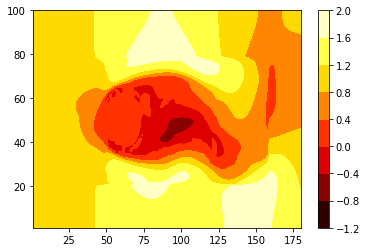

In [157]:
# show time step for control

print 'time ',t

x = cfd1.i.unique()
y = cfd1.k.unique()



X, Y = np.meshgrid(x,y)
nx,ny = X.shape

Z = cfd1.U.values.reshape(nx,ny)
plt.contourf(X,Y,Z, cmap='hot')
plt.colorbar()

plt.show()